## Previsão de UTI para Pacientes com Covid-19

<img src="https://img.olhardigital.com.br/wp-content/uploads/2019/12/20191219064913-1207x450.jpg">

## 1. Introdução

Este projeto de ciência de dados tem como objetivo desenvolver um modelo preditivo para detectar<b> quais pacientes precisarão ser admitidos na UTI</b>, a partir dos dados clínicos individuais do histórico de pacientes atendidos com <b>COVID-19</b>. O dados que serão utilizados neste projeto foram disponilizados pelo <b>Hospital Sírio Libanês - São Paulo e Brasília</b> no [Kaggle](https://www.kaggle.com/) (plataforma de competição de ciência de dados muito conhecida). Este modelo apoiará o hospital na organização e otimização quanto à disponibilidade de leitos para pacientes com COVID-19. Desta forma, a remoção e transferência deste(a) paciente pode ser organizada antecipadamente, evitando a ruptura, e assim, ajudando a <b>salvar vidas</b>.

## 2. Descrição dos Dados

Conforme falado anteriormente, o dataset que utilizaremos para desenvolvimento do modelo são dados clinícos individualizados de pacientes atendidos com COVID-19, disponbilizado pelo <b>Hospital Sírio Libanês</b>. E podemos baixar no portal do Kaggle neste [link](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

#### <b>Características dos Dados:</b>

- Informações demográficas do paciente (03 colunas)
- Doenças anteriores agrupadas de pacientes (09 colunas)
- Resultados de sangue (36 colunas)
- Sinais vitais (06 colunas)

No total são 54 colunas, expandidas quando pertinente à média, mediana, max, min, diff e diff relativo.

- <b>diff</b> = max - min: diferença entra valor máximo e mínimo da medida.
- <b>diff relativo</b> = diff / mediana (diferença dividido pela mediana).


No dataset há uma coluna chamada <b>WINDOW</b>, que utiliza o conceito de Janela, para trazer informações clínicas no período de tempo em que o paciente foi admitido: 

<table>
    <tr><td><b>Janela</b></td><td><b>Descrição</b><td></tr>
    <tr><td>0-2</td><td>De 0 a 2 horas da admissão</td>
    <tr><td>2-4</td><td>De 2 a 4 horas da admissão</td>
    <tr><td>4-6</td><td>De 4 a 6 horas da admissão</td>
    <tr><td>6-12</td><td>De 6 a 12 horas da admissão</td>
    <tr><td>Acima de 12</td><td>Acima de 12 horas a partir da admissão</td>
</table>

## 3. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix

sns.set() # Setar a utilização do seaborn para demonstrar o gráfico.
sns.set_style('whitegrid')

## 4. Carregamento dos Dados

Para o carregamento dos dados utilizaremos ``read_excel`` do pandas, uma vez que os dados então em um arquivo <b>excel</b>.

In [2]:
df = pd.read_excel('https://github.com/diogoslz/Bootcamp-Alura-Modulo-Projeto-final/blob/main/Dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')

In [3]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [5]:
df.shape

(1925, 231)

Ao executar a função ``info`` e ``shape`` em nosso dataframe observamos algumas informações:

- 1925 linhas.
- 231 colunas:
    - 225 do tipo <b>float64</b> (dados contínuos)
    - 4 do tipo <b>inteiro</b> (dados contínuos ou binários)
    - 2 do tipo <b>object</b> (dados categóricos)
- O nome da primera coluna é: <b>PATIENT_VISIT_IDENTIFIER</b> 
- O nome da ultima coluna é: <b>ICU</b>

In [6]:
df.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Para analisar algumas informações estatísticas dos nossos dados, como <b> frequência (count), média (mean), desvio padrão (std), max, min e quartis</b>, utilizamos o método ```describe``` do pandas em nosso dataframe. Por padrão, o método retorna informações dos dados contínuous, por este motivo que não observamos informações dos dados categóricos, como o <b> AGE_PERCENTIL</b>.

In [7]:
print(list(df.columns))

['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATI

Acima listamos todas as colunas em nosso dataframes, total de <b>229 colunas</b>. Então observamos que o dataframe contém informações clínicas dos pacientes com COVID-19:

<b>Informações demográficas do paciente (03 colunas):</b>
- <b>Idade Acima de 65 Anos (AGE_ABOVE65)</b>
- <b>Faixa Etária (AGE_PERCENTIL)</b>
- <b>[Genêro](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/164019) (GENDER)</b>
    0: Masculino
    1: Feminina

<b>Doenças anteriores agrupadas de pacientes (09 colunas):</b>
- <b>Grupo de Doenças 1 (DISEASE GROUPING 1)</b>
- <b>Grupo de Doenças 2 (DISEASE GROUPING 2)</b>
- <b>Grupo de Doenças 3 (DISEASE GROUPING 3)</b>
- <b>Grupo de Doenças 4 (DISEASE GROUPING 4)</b>
- <b>Grupo de Doenças 5 (DISEASE GROUPING 5)</b>
- <b>Grupo de Doenças 6 (DISEASE GROUPING 6)</b>
- <b>Hipertensão (HTN)</b>
- <b>Imunocomprometido (IMMUNOCOMPROMISED)</b>
- <b>Outros (OTHER)</b>

<b>Sinais vitais (6 colunas):</b> 
- <b>Saturação do Oxigênio (OXYGEN_SATURATION)</b>; 
- <b>Frequência Respiratória (RESPIRATORY_RATE)</b>;
- <b>Temperatura (TEMPERATURE)</b>;
- <b>Pressão Sistólica (BLOODPRESSURE_SISTOLIC);</b>
- <b>Pressão Diatolica (BLOODPRESSURE_DIASTOLIC);</b>.
- <b>Frequência Cardíaca (HEART_RATE);</b> 

<b>Exames de sangue (36 colunas):</b>

- <b>Glicose (GLUCOSE)</b>
- <b>Linfócitos (LINFOCITOS)</b>
- <b>PCR</b>
- <b>Creatinina (CREATININ)</b>
- ETC...

## 5. Preenchendo Dados Faltantes

<AxesSubplot:>

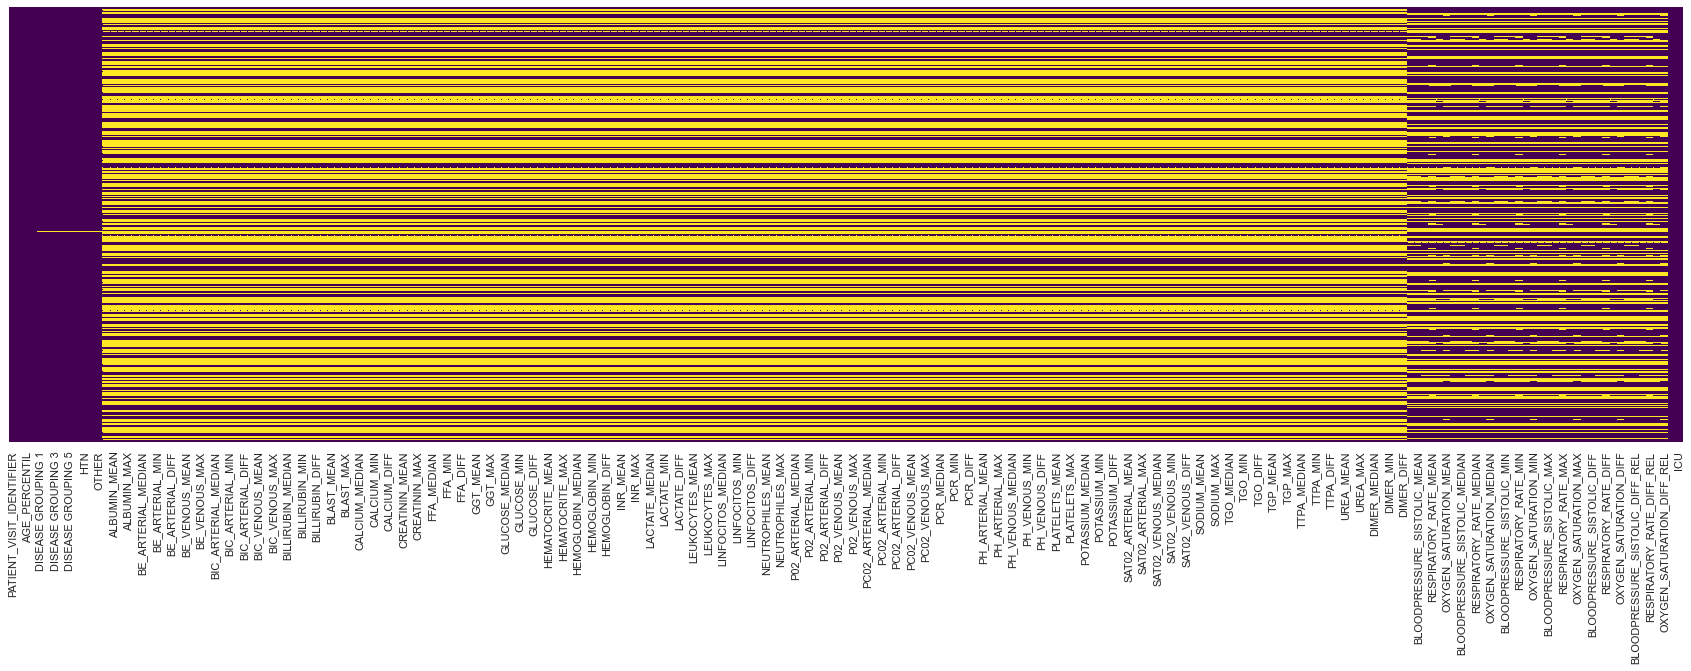

In [8]:
plt.figure(figsize=(30,8))

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Utilizamos o método ```isnull``` do <b>Pandas</b> com  ```heatmap``` do <b>Seaborn</b> para visualizarmos os dados faltantes. Ao gerar o gráfico acima podemos visualizar destacado de amarelo as partes dos dados ausentes em nosso dataframe, o que evidencia uma grande quantidade de dados faltantes.

In [9]:
def preenchertabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas , saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

Ao verificar o gráfico acima, percebemos que somente os dados contínuos estão vazios, ou seja, não temos informações de <b>sinais vitais e exames de sangue em janelas de vários pacientes</b>. 

Para desenvolvermos um modelo, precisaremos que todos os dados vazios sejam <b>preenchidos</b>, e como temos poucos dados para o desenvolvimento do modelo, não podemos simplesmente excluir todas as linhas dos dados vazios com método `dropna` do pandas, podendo afetar negativamente as <b>métricas</b> de avaliação do modelo. 

Neste caso específico, como são dados clínicos, é muito improvável que valores medidos da <b> pressão, ou frequência cardíaca</b> mudem repentinamente para outro valor muito diferente, em janelas próximas. Então, podemos deduzir que é <b>alta a probabilidade das informações de exames e sinais vitais coletados em janelas próximas de cada paciente sejam iguais, ou seja, são dados altamente dependentes e por isso repetiremos os dados faltantes com as informações da janela mais próxima</b>.

Para resolver esse problema:
- Criaremos uma função para separar os dados em: colunas contínuas, categóricas e saída. 
- Em seguida, tratamos os dados contínuos já separados com `fillna` com parâmetro method `bfill`, onde ele preenche a medida vazia anterior repetindo a medida posterior. 
- Também utilizamos o `fillna` com parâmetro method `ffill`, onde ele peenche a medida vazia posterior repetindo a medida anterior.

In [10]:
df_limpos = preenchertabela(df)
df_limpos = df_limpos.dropna()

<AxesSubplot:>

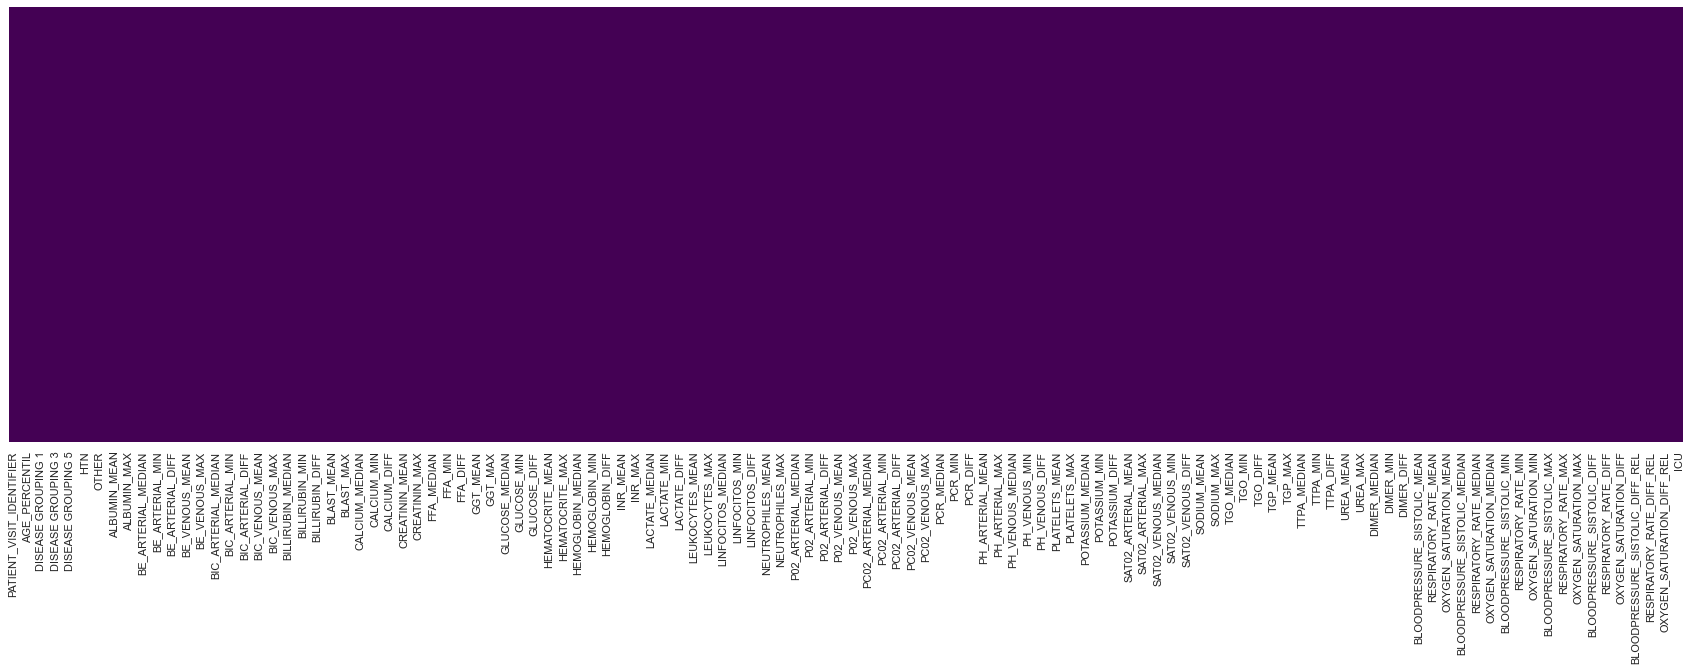

In [11]:
plt.figure(figsize=(30,8))

sns.heatmap(df_limpos.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Pronto! Ao visualizar novamente os dados com o gráfico ``heatmap`` com ``isnull``, percebemos que não existe mais partes destacados de amarelo no gráfico, o que demonstra que não existem dados faltantes em nosso dataframe.

## 6. Levantamento de Hipóteses

<img src="https://media1.tenor.com/images/4c6187594727c6937f0ed9c4cbaf7249/tenor.gif?itemid=8949118">

Antes da análise exploratória, vamos levantar algumas hipóteses de como a evolução do quadro clínico de pacientes – registrado nos exames laboratoriais e sinais vitais, coletados durante o período de internação – influenciou na internação em UTI (ICU).

É de comum conhecimento que existe um grupo de risco COVID-19 e esse grupo envolve pessoas com <b>mais idade, obesas (ou com péssimos hábitos alimentares) e doenças crônicas (como Diabéticos, Hipertensos, Imunodeficientes...)</b>. Para a nossa "sorte", essas informações foram disponiblizados pelo Hospital Sírio Libanês. Com isso em mente podemos levantar algumas perguntas:

1. <b>Pessoas com mais idade tendem a ir para a UTI?</b>
2. <b>Qual grupo de risco é mais propenso?</b>
3. <b>Existe um genêro predominante?</b>
4. <b>Podemos correlacionar resultados dos exames laboratoriais com ida da pessoas para a UTI?</b>

Com essas perguntas em mente, podemos desenvolver a análise explorátória para respondê-las.

## 7. Análise Exploratória dos Dados

Então vamos começar a análise exploratória! Começaremos pelas informações demográficas dos pacientes por COVID-19: <b>AGE_PERCENTIL, GENDER e AGE_ABOVE65.</b>

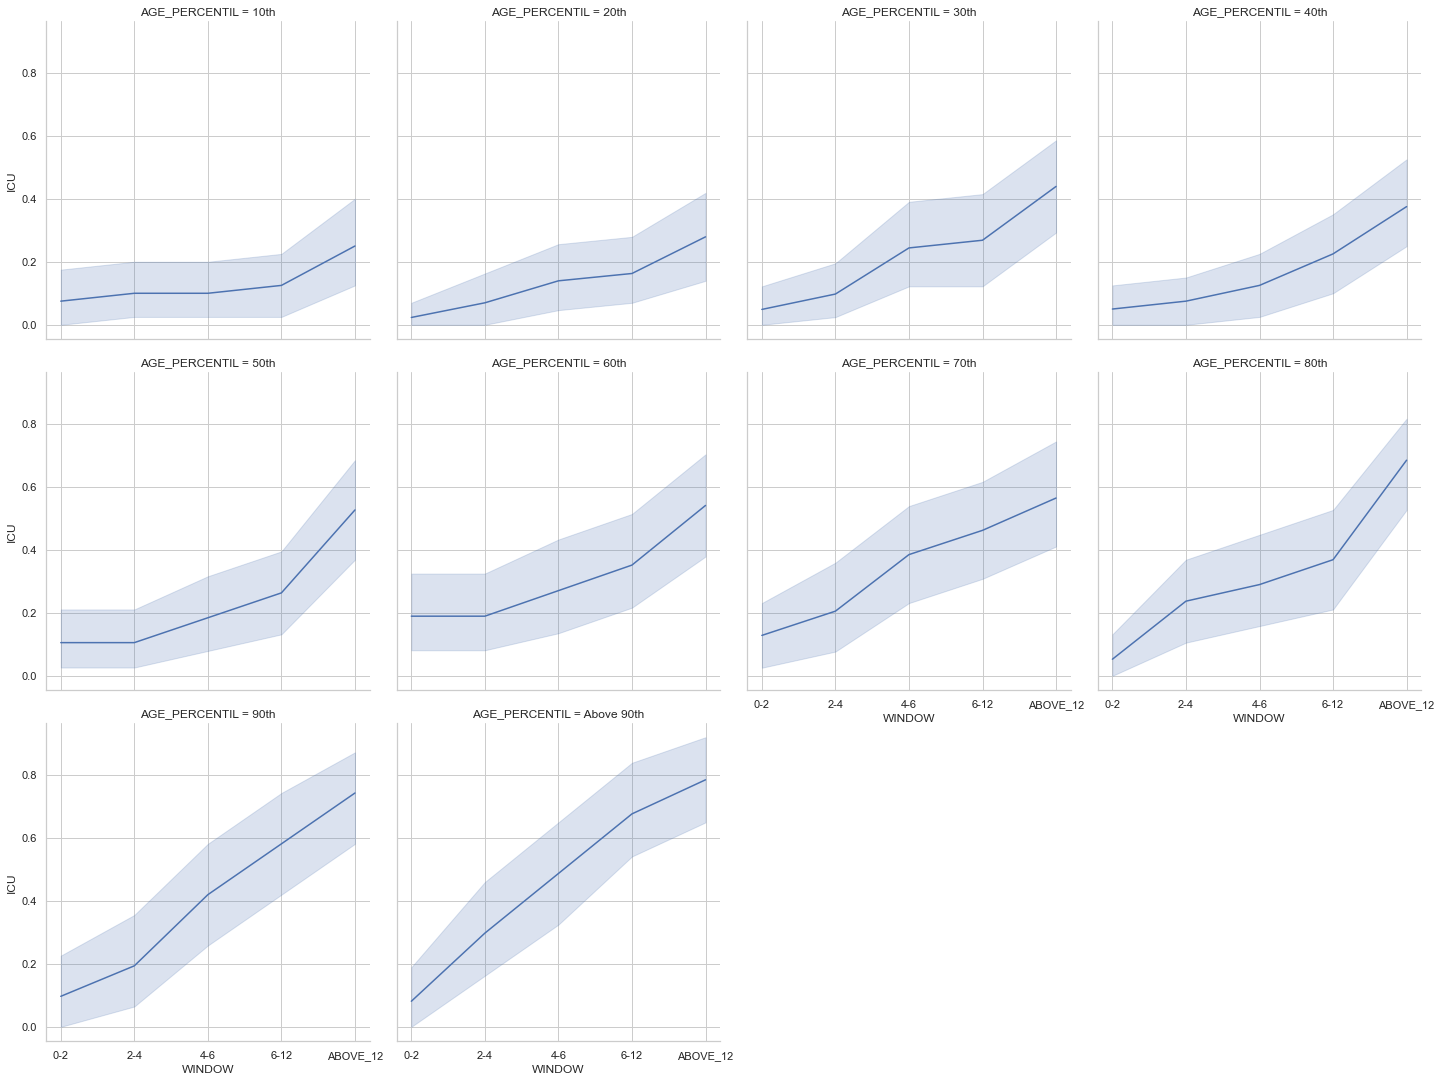

In [12]:
sns.relplot('WINDOW','ICU',col='AGE_PERCENTIL', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['AGE_PERCENTIL','WINDOW']))
plt.show()

Visualizando para o gráfico **RelPlot** acima, podemos facilmente inferir que a chance de **Pacientes na Faixa Etária acima de 90 anos** de serem internadas na UTI depois das **12 primeiras horas internação** é de cerca de **79-80%**.

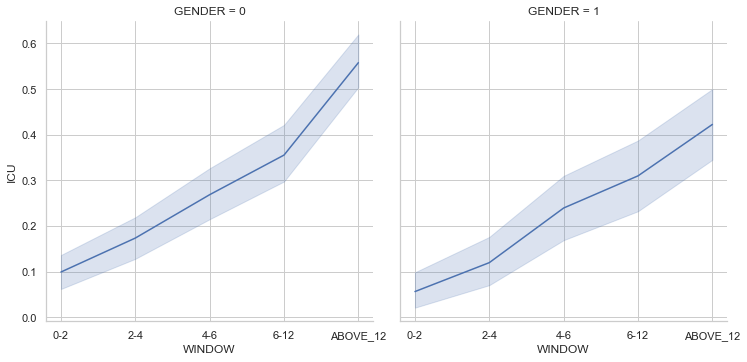

In [13]:
sns.relplot('WINDOW','ICU',col='GENDER', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['GENDER','WINDOW']))
plt.show()

Neste outro gráfico, podemos visualizar que ao passar do tempo de internação, a chance de **pacientes do Genêro Masculo** chega a ser de **56%** depois das 12 horas de internação. Comparado com **pacientes do Genêro Feminimo, as chances são 14% maior**.

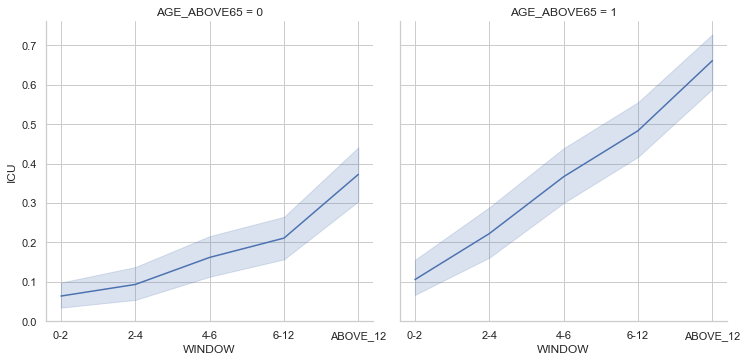

In [14]:
sns.relplot('WINDOW','ICU',col='AGE_ABOVE65', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['AGE_ABOVE65','WINDOW']))
plt.show()

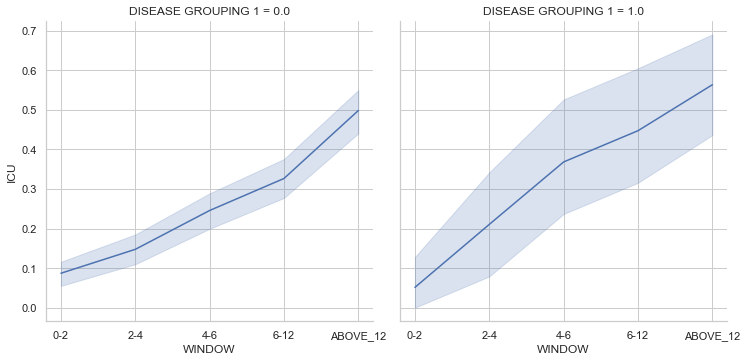

In [15]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 1', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 1','WINDOW']))
plt.show()

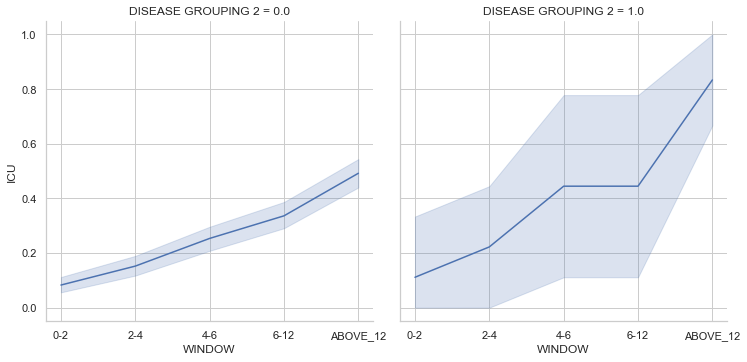

In [16]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 2', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 2','WINDOW']))
plt.show()

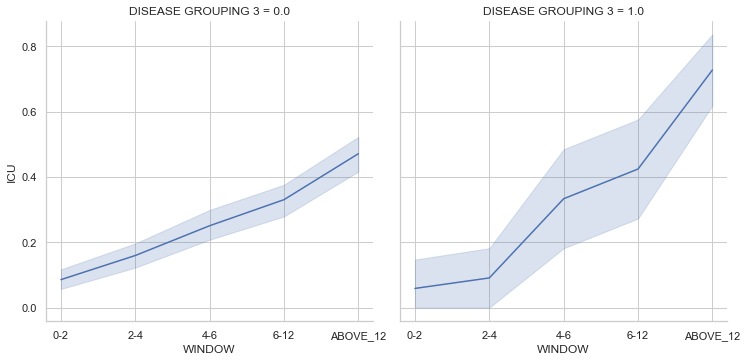

In [17]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 3', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 3','WINDOW']))
plt.show()

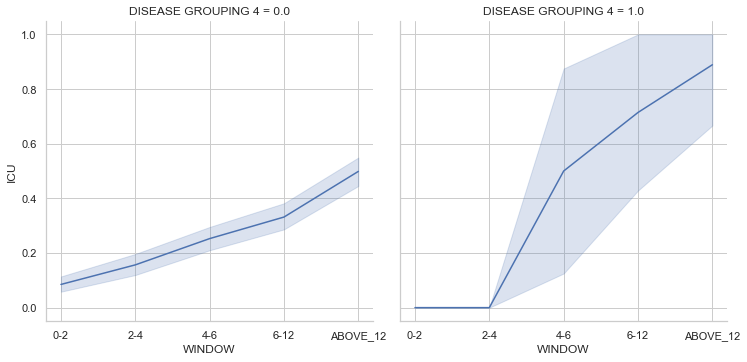

In [18]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 4', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 4','WINDOW']))
plt.show()

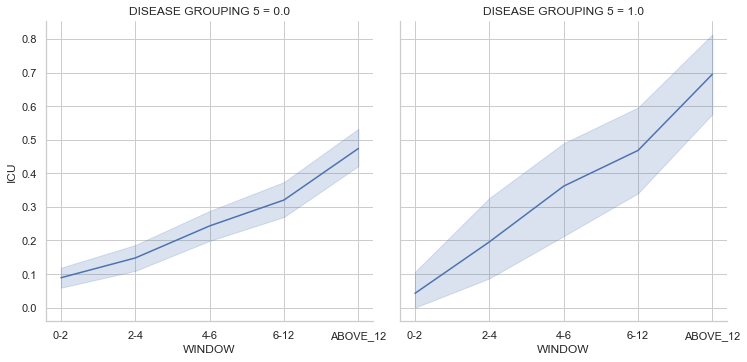

In [19]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 5', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 5','WINDOW']))
plt.show()

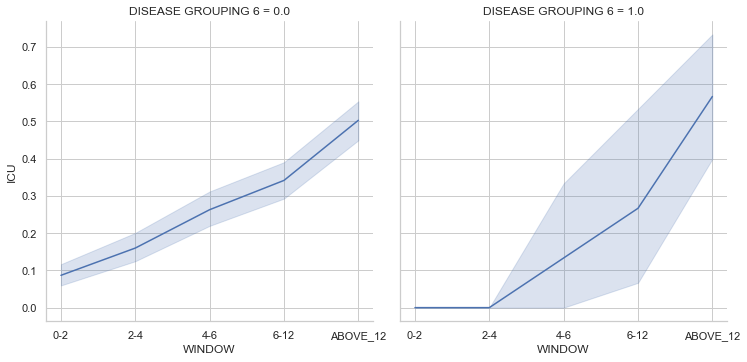

In [20]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 6', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 6','WINDOW']))
plt.show()

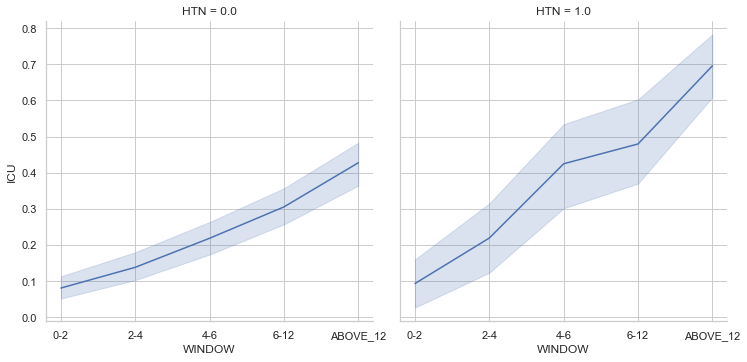

In [21]:
sns.relplot('WINDOW','ICU',col='HTN', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['HTN','WINDOW']))
plt.show()

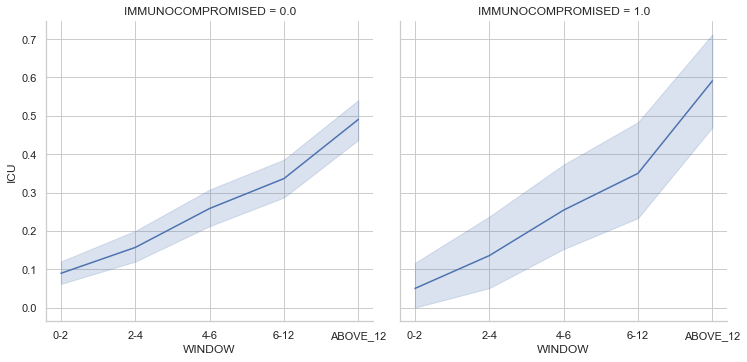

In [22]:
sns.relplot('WINDOW','ICU',col='IMMUNOCOMPROMISED', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['IMMUNOCOMPROMISED','WINDOW']))
plt.show()

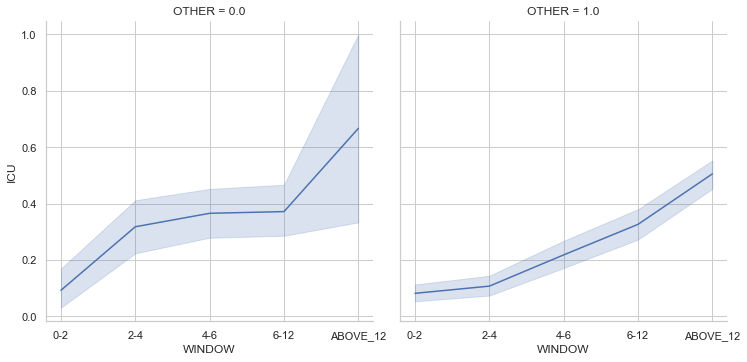

In [23]:
sns.relplot('WINDOW','ICU',col='OTHER', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['OTHER','WINDOW']))
plt.show()

<AxesSubplot:>

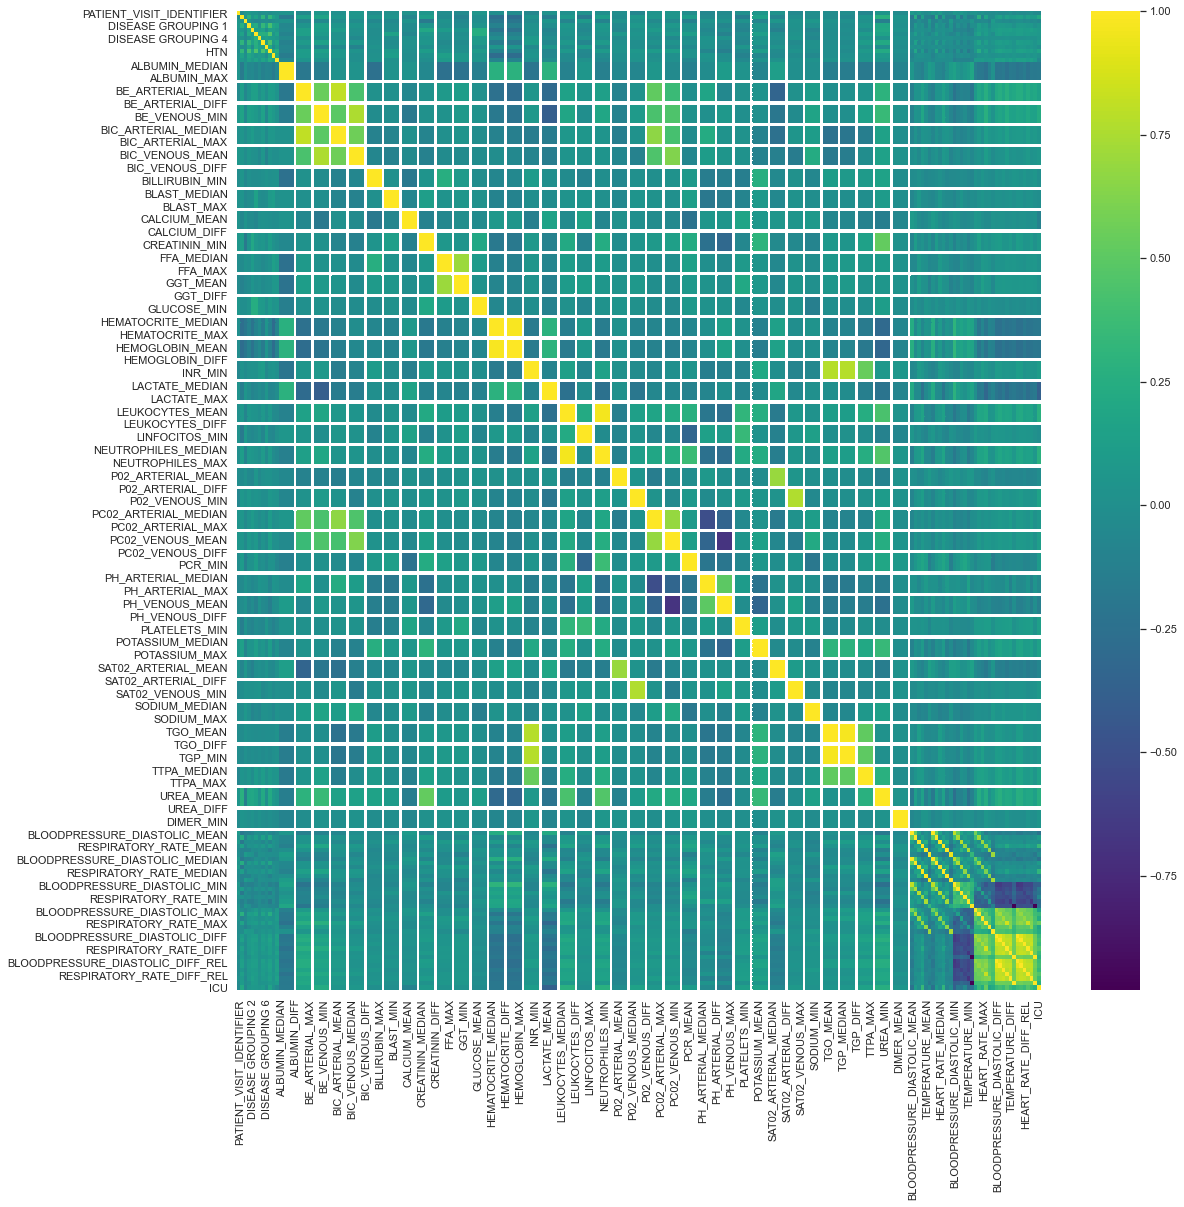

In [24]:
plt.figure(figsize=(18,18))

sns.heatmap(df_limpos.corr(),cmap='viridis')

Para analisarmos as correlações entre as variáveis, utilizamos o médodo `corr` em nosso dataframe e plotamos com`heatmap` do seaborn. Ao analisar o gráfico, percebemos fortes correlações (valores próximos de 1) entre as variáveis expandidas. Isso é natural, uma vez que são **de uma só origem**. Por exemplo: **OXYGEN_SATURATION_MIN, OXYGEN_SATURATION_MAX, OXYGEN_SATURATION_DIFF e OXYGEN_SATURATION_DIFF_REL**. Elas serão altamente correlacionáveis porque, no fim das contas, os valores dessas variáveis se originam da **Saturação do Oxigênio**.

Porém, ao visualizar o gráfico percebemos que as variáveis expandidas dificultam muito a nossa análise de correlações, pois, além de elevar a régua de correlação, o gráfico fica muito extenso devido ao **grande número de variáveis**. 

Para visualizarmos as correlações entre as informações de exames e sinais vitais, selecionamos **somente a Média** desses valores, utilizando o método `contains` nos nomes das colunas.

In [25]:
medias = df_limpos.columns.str.contains('MEAN')

In [26]:
analise_medias = df_limpos[df_limpos.columns[medias]]

analise_medias['ICU'] = df_limpos['ICU']
analise_medias.head()

,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,...,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,ICU
0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0
1,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0
2,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,0
3,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,-0.859275,...,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,0
4,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,-0.859275,...,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,1


<AxesSubplot:>

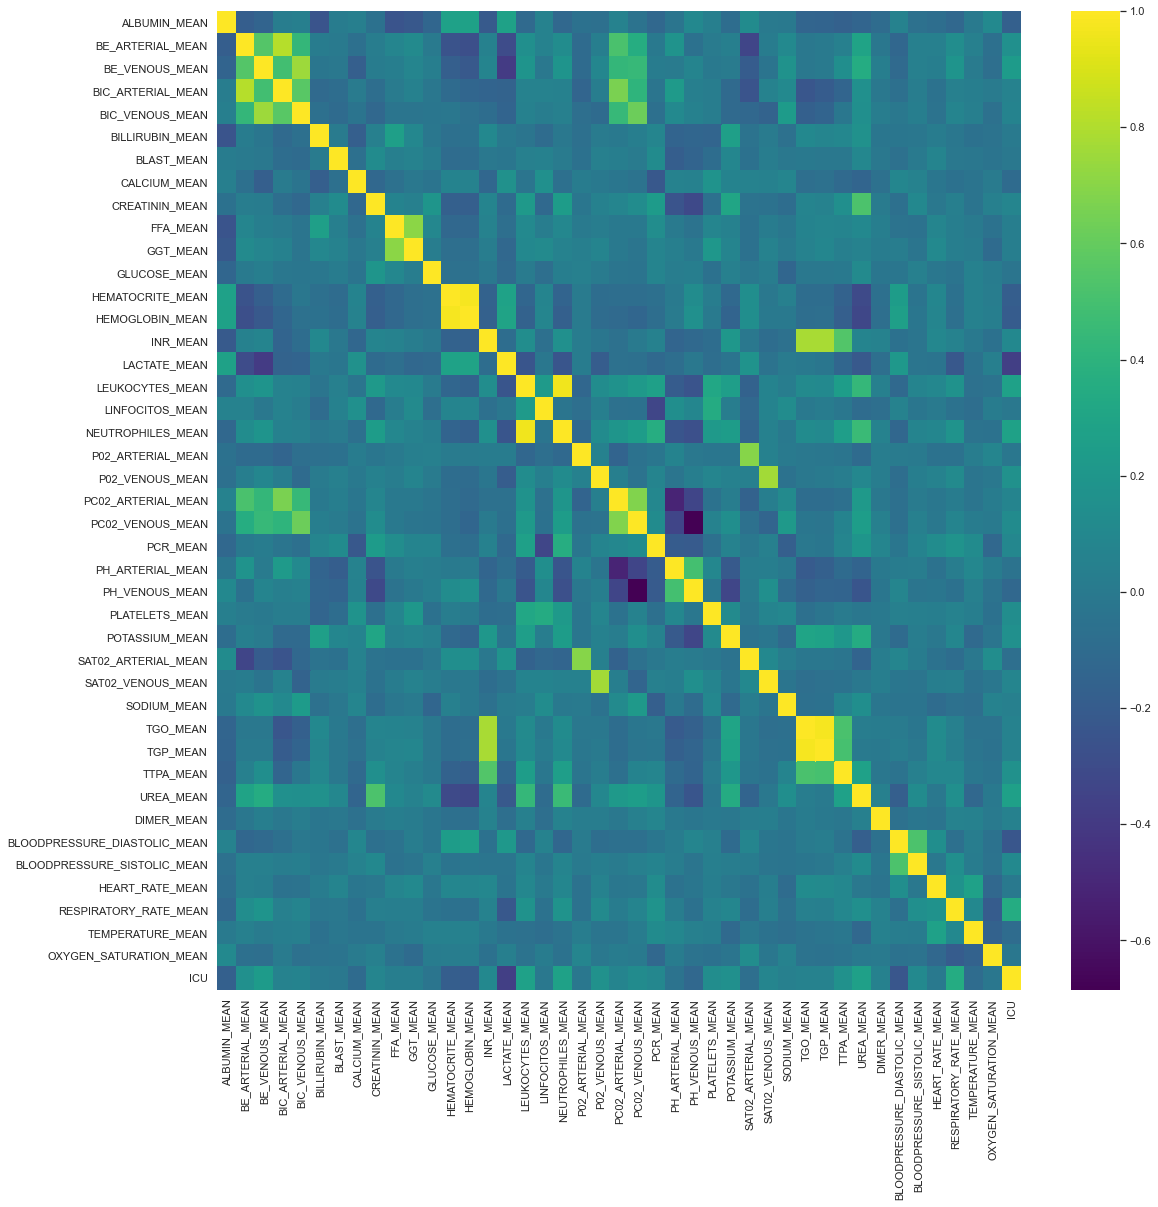

In [27]:
plt.figure(figsize=(18,18))

sns.heatmap(analise_medias.corr(),cmap='viridis')

In [28]:
analise_medias.corr()['ICU']

ALBUMIN_MEAN                   -0.174812
BE_ARTERIAL_MEAN                0.151272
BE_VENOUS_MEAN                  0.230357
BIC_ARTERIAL_MEAN               0.054201
BIC_VENOUS_MEAN                 0.068164
BILLIRUBIN_MEAN                 0.002137
BLAST_MEAN                     -0.008575
CALCIUM_MEAN                   -0.104013
CREATININ_MEAN                  0.082518
FFA_MEAN                        0.029775
GGT_MEAN                        0.029995
GLUCOSE_MEAN                   -0.029972
HEMATOCRITE_MEAN               -0.185316
HEMOGLOBIN_MEAN                -0.201393
INR_MEAN                        0.104373
LACTATE_MEAN                   -0.369370
LEUKOCYTES_MEAN                 0.274121
LINFOCITOS_MEAN                -0.007485
NEUTROPHILES_MEAN               0.280044
P02_ARTERIAL_MEAN              -0.016193
P02_VENOUS_MEAN                 0.159333
PC02_ARTERIAL_MEAN              0.073401
PC02_VENOUS_MEAN                0.123445
PCR_MEAN                        0.097697
PH_ARTERIAL_MEAN

Agora sim! Depois que selecionamos somente a MÉDIA, ficou mais fácil explorar as correlações entre as variáveis.

Ao analisar as correlações das váriaveis que correspondem aos **exames de sangue** e **sinais vitais**, com o nosso target para a previsão: **ICU**, percebemos que temos duas váriaveis que se destacam tanto positivamente quanto negativamente, respectivamente: a **Frequência Respiratória (RESPIRATORY_RATE_MEAN) com p igual a 0,35 e a LACTATE_MEAN com p igual a -0.36**. Com esses valores de p, podemos concluir que nenhuma variável correspondende a exames de sangue tem uma **correlação forte** com o nosso target **ICU**.

Para melhor entendimento sobre correlação,  segue abaixo o trecho de um artigo muito bom sobre **Análise de correlação usando Python e R da [Amanda Munari Guimarães](https://medium.com/@amandamunariguimares)** no [Medium](https://medium.com/), para acessar basta clicar neste [link](https://medium.com/omixdata/estat%C3%ADstica-an%C3%A1lise-de-correla%C3%A7%C3%A3o-usando-python-e-r-d68611511b5a):

>Quando falamos em análise de dados, muitas vezes precisamos entender qual é a associação entre duas ou mais variáveis. Nesse caso, a análise de correlação é uma forma descritiva que mede se há e qual o grau de dependência entre variáveis, ou seja, o quanto uma variável interfere em outra. Lembrando que essa relação de dependência pode ou não ser causal. Essa medida de grau de relação é medida através de coeficientes. No caso deste post, nós vamos focar no coeficiente de Pearson.

>O coeficiente de Pearson, também chamado de “coeficiente de correlação produto-momento” ou chamado de “ρ de Pearson”, mede o grau de correlação através do cálculo de direção positiva ou negativa. Este coeficiente, normalmente representado por ρ assume apenas valores entre -1 e 1.

>A análise de correlação vai retornar três possíveis cenários: (1) correlação positiva; (2) correlação negativa; e (3) não há correlação.

>- **Correlação positiva:** quando duas variáveis que possuem correlação crescem ou decrescem juntas, ou seja, que possuem uma relação direta;
>- **Correlação negativa:** quando duas variáveis que possuem correlação mas quando uma variável cresce a outra decresce, ou vice-versa;
>- **Não ter correlação:** quando o crescimento ou decrescimento de uma variável não tem efeito sobre outra variável.
Como podemos interpretar os valores que ρ pode assumir?

>- **ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;**
>- **ρ = 0,7 a 0,9 (positivo ou negativo): correlação forte;**
>- **ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;**
>- **ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;**
>- **ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.**

## 8. Seleção de Dados para Previsão

In [29]:
df_limpos[['PATIENT_VISIT_IDENTIFIER','WINDOW','ICU']].head()

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1


Como descrito e analisado anteriormente, percebemos que no dataframe que utilizaremos para a previsão, existe uma coluna chamada **WINDOW**, onde essa coluna registra as informações da janela de tempo em que o paciente está internado. Verificamos também que existe uma coluna **PATIENTE_VISIT_IDENTIFIER**, essa coluna registra a identificação do paciente. Isto é, em nosso dataframe contém informações da evolução clínica – com exames de sangue e sinais vitais – durante o período de internação.

Pensando nesse cenário, uma vez que temos que antecipar a ação do paciente antes de ir para a UTI, não faria sentido usar as informações clínicas depois que o paciente já foi internado na UTI para treinar o nosso modelo. Isso poderia deixá-lo **enviesado**, pois pode ocorrer do paciente ir direto para UTI **na primeira janela (pacientes com informações 0-2 na coluna WINDOW, com ICU igual a 1)**, e depois, ocorrer os exames de sangue e a coleta dos sinais vitais. Para os novos pacientes, com modelo já funcionando, ele não teria essas informações se o paciente for direto da UTI, já que a coleta foi depois.

Para evitar esse problema (e desenvolvermos um modelo que faça sentido), precisamos remover todos os pacientes que foram **direto para a UTI na primeira janela**. Para isso, selecionamos a coluna **PATIENTE_VISIT_IDENTIFIER** e utilizamos o método `query`+ `values` em nosso dataframe para selecionar somente os IDs dos pacientes na **janela 0-2** e **ICU igual a 1**, então guardarmos essa informação na variável `remover`.

In [30]:
remover = df.query("WINDOW == '0-2' and ICU == 1")['PATIENT_VISIT_IDENTIFIER'].values

In [31]:
remover

array([  1,  17,  27,  41,  47,  48,  54,  62,  85,  90, 104, 106, 109,
       117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306,
       315, 329, 359, 362, 366, 379], dtype=int64)

In [32]:
print('Total de pacientes que foram direto para UTI na primeira janela:', len(remover))

Total de pacientes que foram direto para UTI na primeira janela: 32


Com a lista de **IDs desses pacientes na váriável `remover`**, podemos utilizá-lo como parâmetro no método `query` para fazermos um `not in` (para não incluir) e então redefinimos o nosso dataframe `df_limpos` sem esses pacientes.

In [33]:
df_limpos = df_limpos.query("PATIENT_VISIT_IDENTIFIER not in  @remover")
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Examinando os dados, me veio outra questão: **Devemos utilizar todas as janelas de tempo de um paciente para previsão?**

A análise exploratória já provou que quanto mais janelas utilizarmos para o treinamento do modelo, melhor será a precisão. 

**Porém, quanto mais antecipada a nossa previsão, mais valioso nosso modelo será para o Hospital Sírio Libanês**. Não concordas? Por este motivo, vamos selecionar somente as informações da primeira janela (inclusive, essa é uma dica dada pelo próprio hospital no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)). 

**Temos mais um porém aqui!** Se fizermos somente o filtro da primeira janela em nosso dataframe `df_limpos`, perderíamos todas as informações de pacientes que foram para UTI, uma vez que os excluímos logo na primeira janela. E não é isso que queremos.

Para tanto, criamos um método (`prepare_window`) que vai buscar em **todas as janelas (método `any` do numpy)** a informação na coluna **ICU** de que o paciente foi para a UTI (1: SIM ou 0: NÃO) e preencherá com esta informação a linha que representa a primeira **janela (até 2 horas de admissão)**. 

Para finalizar o método, selecionamos a linha que representa a primeira janela com a coluna **ICU já atualizada**. Com isso, teremos uma linha para cada paciente com informações da primera janela e, na coluna ICU a informação de que ele foi para **UTI preenchida**.

In [34]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2','ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

In [35]:
df_limpos = df_limpos.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False ).apply(prepare_window)
df_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


## 9. Análise Exploratória dos Dados (Parte 2)

Em posse dos dados "limpos" para o **treinamento, teste e validação do nosso modelo preditivo**, vamos realizar mais análises exploratórias para verificarmos se as informações que temos poderão ser importantes para a predição, e também, validar ainda mais as hipóteses levantadas.

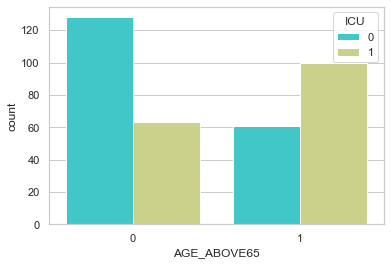

In [36]:
ax = sns.countplot(x="AGE_ABOVE65", hue="ICU", data=df_limpos, palette='rainbow')

No gráfico acima, percebemos uma frequência maior de pacientes que foram para a UTI com idade **acima de 65 cima (AGE_ABOVE65)**.

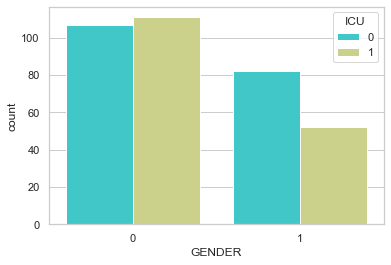

In [37]:
ax = sns.countplot(x="GENDER", hue="ICU", data=df_limpos, palette='rainbow')

No gráfico acima, percebemos uma predominância do genêro Masculino em nosso dataframe, e que a frequência dentre os homens que foram para UTI superou um pouco dos que não foram **(GENDER igual 0)**. Comparado ao gênero Feminino, os homens estão bem na frente!

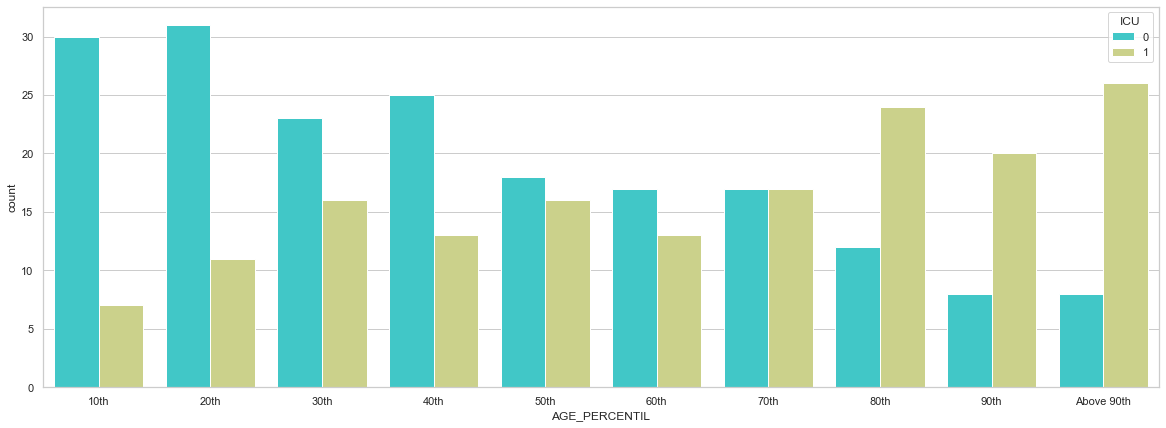

In [38]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(x='AGE_PERCENTIL',hue='ICU',data=df_limpos.sort_values(by='AGE_PERCENTIL'), palette='rainbow')
plt.show()

O gráfico acima evidencia a análise feita anteriormente: quanto **mais idade o paciente tem**, maior é a tendência de parar na UTI.

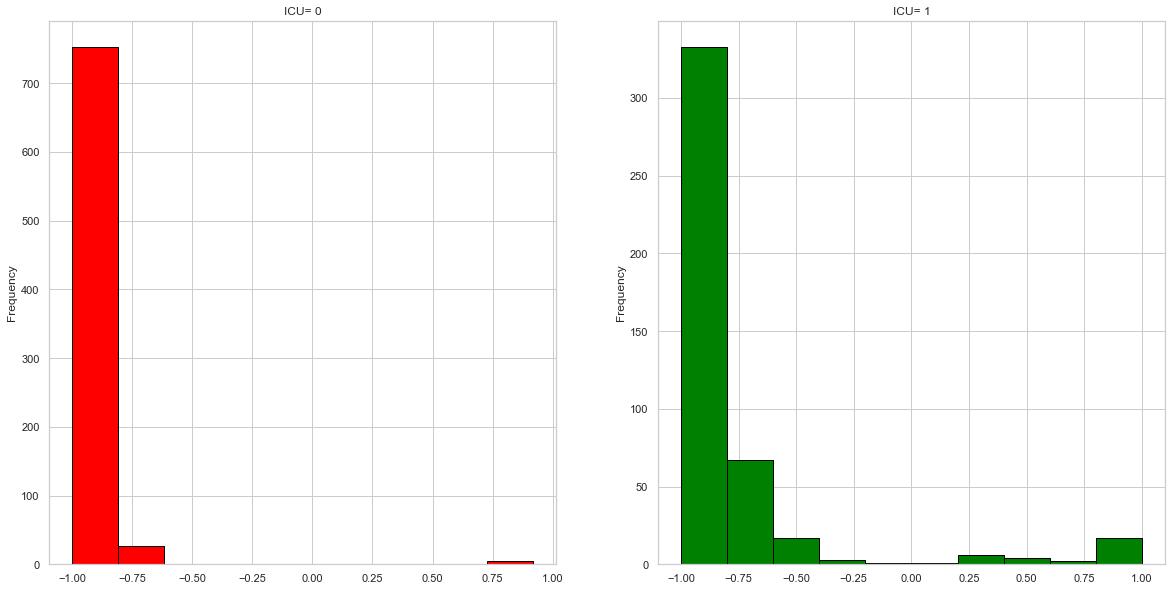

In [39]:
f,ax=plt.subplots(1,2,figsize=(20,10))
df[df['ICU']==0].OXYGEN_SATURATION_DIFF.plot.hist(ax=ax[0],edgecolor='black',color='red')
ax[0].set_title('ICU= 0')
df[df['ICU']==1].OXYGEN_SATURATION_DIFF.plot.hist(ax=ax[1],color='green',edgecolor='black')
ax[1].set_title('ICU= 1')
plt.show()

Nos gráficos do histograma acima, onde plotamos os valores da **diferença entre o máximo e o mínimo** das saturações do oxigênio aferidas (OXYGEN_SATURATION_DIFF), percebemos uma dispensão maior para os pacientes que foram para UTI.

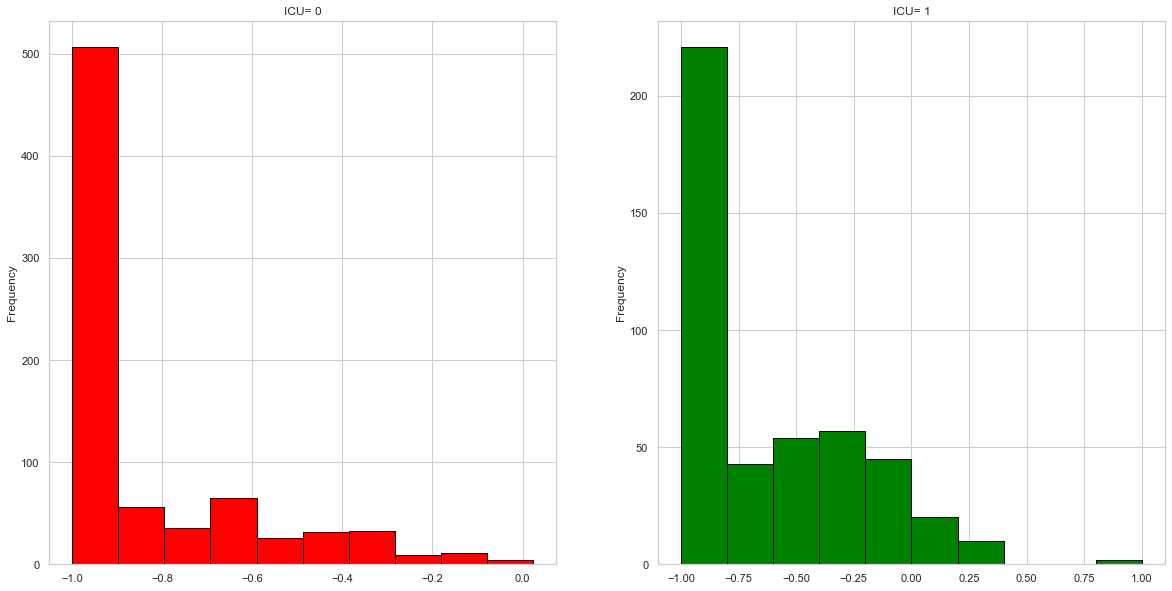

In [40]:
f,ax=plt.subplots(1,2,figsize=(20,10))
df[df['ICU']==0].TEMPERATURE_DIFF.plot.hist(ax=ax[0],edgecolor='black',color='red')
ax[0].set_title('ICU= 0')
df[df['ICU']==1].TEMPERATURE_DIFF.plot.hist(ax=ax[1],color='green',edgecolor='black')
ax[1].set_title('ICU= 1')
plt.show()

Nos gráficos de histograma acima, onde plotamos os valores da **diferença entre o máximo e o mínimo** das temperaturas aferidas (TEMPERATURE_DIFF), percebemos uma dispensão menor, porém, uma frequência maior de pacientes com **maiores variações entre a temperatura máxima e mínima**, para os pacientes que foram para a UTI.

## 10. Conclusões

Para a conclusão, vamos responder as hipóteses levantadas utilizadas como guia para o desenvolvimento da análise exploratória:

1. <font color='red'><b> Pessoas com mais idade tem mais tendência a ir para a UTI?</b></font>
    
    **Podemos concluir nas análises feitas que os pacientes com mais idade têm uma tendência maior de serem internados na UTI. Visualizamos nos gráficos relplot e countplot que váriaveis relacionadas à idade do paciente como (AGE_PERCENTIL e AGE_ABOVE65), podem influenciar positivamente na acuracidade do nosso modelo preditivo.**
    
    
2. <font color='red'><b> Qual grupo de risco é mais propenso? </b></font>

    **Podemos inferir com as análises feitas que pacientes que fazem parte do grupo de doenças 4 (DISEASE GROUPING 4) têm uma tendência maior de serem internados na UTI. Chegando a 89% (em média) de chances de parar na UTI, quando estão a mais de 12 horas de internação.**


3. <font color='red'><b> Existe um genêro predominante de pacientes indo para a UTI? </b></font>

    **Podemos concluir nas análise feitas que pacientes do gênero Masculino têm uma tendência maior de serem internados na UTI. Chegando a 56% (em média) de chances de parar na UTI. Ou seja, comparado aos 44% de chances do gênero Feminino, os homens têm 12% a mais de serem internados na UTI.**
    
    
4. <font color='red'><b>Os resultados dos exames laboratoriais tem correlação com ida da pessoas para a UTI? </b></font> 
    
    **Na análise exploratória selecionamos somente as variáveis com a média dos resultados dos exames de sangue e dos sinais vitais, e verificamos com o método `corr` a correlação entre elas e também com o nosso target ICU. O resultado que tivemos foram duas variáveis com uma correlação moderada: RESPIRATORY_RATE_MEAN e LACTATE_MEAN**. 

## 11. Referências

- [Alura](https://www.alura.com.br/);
- [Medium](https://medium.com/);
- [Estatística: análise de correlação usando Python e R](https://medium.com/omixdata/estat%C3%ADstica-an%C3%A1lise-de-correla%C3%A7%C3%A3o-usando-python-e-r-d68611511b5a);
- [Bootcamp Data Science Aplicada](https://www.alura.com.br/bootcamp/data-science-aplicada/matriculas-abertas);
- [Storytelling with Data](https://www.storytellingwithdata.com/);
- [Seaborn](https://seaborn.pydata.org/);
- [Numpy](https://numpy.org/](https://numpy.org/);
- [Pandas](https://pandas.pydata.org/](https://pandas.pydata.org/);
- [Matplotlib](https://matplotlib.org/](https://matplotlib.org/)

## 12. Contatos

Alguma dica, dúvida ou sugestão? Fique à vontade para contatar:

- https://www.linkedin.com/in/diogo-miranda-de-azevedo-63758425/
- https://github.com/diogoslz
- diogonick@gmail.com